In [7]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)  #The findFiles function uses glob.glob to find files matching a specified pattern.

print(findFiles('data.zip'))
!unzip data.zip

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):   #The unicodeToAscii function converts Unicode strings to ASCII, removing diacritics and non-ASCII characters.
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) #Normalization form decomposition
        if unicodedata.category(c) != 'Mn' #The list comprehension filters out characters that are diacritical marks
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n') #The file is opened with UTF-8 encoding, read into a single string, stripped of leading and trailing whitespace, and split into lines.
    return [unicodeToAscii(line) for line in lines]  #returns the lines in ASCII format.

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)


['data.zip']
Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  
Slusarski


In [8]:
all_categories

['Portuguese',
 'Arabic',
 'Russian',
 'Japanese',
 'German',
 'French',
 'Spanish',
 'Chinese',
 'Polish',
 'English',
 'Czech',
 'Irish',
 'Korean',
 'Italian',
 'Scottish',
 'Vietnamese',
 'Dutch',
 'Greek']

In [9]:
category_lines

{'Portuguese': ['Abreu',
  'Albuquerque',
  'Almeida',
  'Alves',
  'Araujo',
  'Araullo',
  'Barros',
  'Basurto',
  'Belo',
  'Cabral',
  'Campos',
  'Cardozo',
  'Castro',
  'Coelho',
  'Costa',
  'Crespo',
  'Cruz',
  "D'cruz",
  "D'cruze",
  'Delgado',
  'De santigo',
  'Duarte',
  'Esteves',
  'Fernandes',
  'Ferreira',
  'Ferreiro',
  'Ferro',
  'Fonseca',
  'Franco',
  'Freitas',
  'Garcia',
  'Gaspar',
  'Gomes',
  'Gouveia',
  'Guerra',
  'Henriques',
  'Lobo',
  'Machado',
  'Madeira',
  'Magalhaes',
  'Maria',
  'Mata',
  'Mateus',
  'Matos',
  'Medeiros',
  'Melo',
  'Mendes',
  'Moreno',
  'Nunes',
  'Palmeiro',
  'Paredes',
  'Pereira',
  'Pinheiro',
  'Pinho',
  'Ramires',
  'Ribeiro',
  'Rios',
  'Rocha',
  'Rodrigues',
  'Romao',
  'Rosario',
  'Salazar',
  'Santana',
  'Santiago',
  'Santos',
  'Serafim',
  'Silva',
  'Silveira',
  'Simoes',
  'Soares',
  'Souza',
  'Torres',
  'Vargas',
  'Ventura'],
 'Arabic': ['Khoury',
  'Nahas',
  'Daher',
  'Gerges',
  'Nazari'

In [10]:
print(category_lines['Italian'][:5])


['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [11]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [93]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size,output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.input_size = input_size
    self.output_size = output_size

    self.lstm=nn.LSTM(input_size,hidden_size)

    self.i2o=nn.Linear(hidden_size,output_size)
    self.softmax=nn.LogSoftmax(dim=1)
  def forward(self ,input,  h0=None ,c0=None):

    input=input.view(1,-1,self.input_size)
    if h0 is None or c0 is None:
      h0 = torch.zeros(1, input.size(0), self.hidden_size)
      c0 = torch.zeros(1, input.size(0) , self.hidden_size)
    output , (hn,cn)=self.lstm(input,(h0,c0))


    output=self.i2o(output[-1])

    output=self.softmax(output)
    return output,hn,cn
  def initHidden(self):
    return torch.zeros(1, 1,self.hidden_size)

n_hidden = 8
rnn = RNN(n_letters, n_hidden, n_categories)


In [94]:
input = letterToTensor('A')
hidden = torch.zeros(1,1, n_hidden)

output, next_hidden_1, next_hidden_1 = rnn(input, hidden,hidden)
print(output)

tensor([[-2.8497, -2.8977, -2.6221, -2.9604, -2.8841, -3.3112, -2.8804, -2.9488,
         -2.7861, -3.1216, -2.8066, -2.6918, -2.7627, -3.0431, -2.7928, -2.9279,
         -2.8774, -3.0819]], grad_fn=<LogSoftmaxBackward0>)


In [95]:
input = lineToTensor('Albert')
hidden = torch.zeros(1,1, n_hidden)

output, next_hidden_1, next_hidden_1 = rnn(input[0], hidden,hidden)
print(output)

tensor([[-2.8497, -2.8977, -2.6221, -2.9604, -2.8841, -3.3112, -2.8804, -2.9488,
         -2.7861, -3.1216, -2.8066, -2.6918, -2.7627, -3.0431, -2.7928, -2.9279,
         -2.8774, -3.0819]], grad_fn=<LogSoftmaxBackward0>)


In [96]:
def categoryFromOutput(output):
    # Get the top category index from the model's output
    top_n, top_i = output.topk(1)  # Returns the highest value and its index
    category_i = top_i[0].item()   # Convert the top index tensor to a Python integer
    return all_categories[category_i], category_i  # Return the category name and its index

# Example usage: print the category name and index for the given output
print(categoryFromOutput(output))


('Russian', 2)


In [97]:
import random

# Function to choose a random element from a list ``l``
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Function to create a random training example
def randomTrainingExample():
    # Choose a random category (language)
    category = randomChoice(all_categories)

    # Choose a random line (name) from the chosen category
    line = randomChoice(category_lines[category])

    # Create a tensor for the category (as an index in all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    # Convert the line to a tensor using the lineToTensor function
    line_tensor = lineToTensor(line)

    # Return the category, line, and their respective tensors
    return category, line, category_tensor, line_tensor

# Loop to print 10 random training examples
for i in range(10):
    # Get a random training example
    category, line, category_tensor, line_tensor = randomTrainingExample()

    # Print the category and line
    print('category =', category, '/ line =', line)


category = Portuguese / line = Mendes
category = Polish / line = Kaluza
category = Japanese / line = Natsume
category = English / line = Dunn
category = English / line = Mcshane
category = Chinese / line = Shuai
category = Italian / line = Alemagna
category = Japanese / line = Tono
category = Japanese / line = Ugaki
category = Vietnamese / line = Nghiem


In [98]:
criterion = nn.NLLLoss()

In [99]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden_1 = rnn.initHidden()
    hidden_2 = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden_1,hidden_2 = rnn(line_tensor[i], hidden_1,hidden_2)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate (this is done instead of optimizer.step())
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [102]:
import time
import math

# Number of iterations to train
n_iters = 100000

# Print progress every ``print_every`` iterations
print_every = 5000

# Record loss for plotting every ``plot_every`` iterations
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# Function to calculate the elapsed time since ``since`` in minutes and seconds
def timeSince(since):
    now = time.time()  # Current time
    s = now - since  # Elapsed time in seconds
    m = math.floor(s / 60)  # Convert seconds to minutes
    s -= m * 60  # Remaining seconds after converting to minutes
    return '%dm %ds' % (m, s)  # Format as "Xm Ys"

start = time.time()  # Record the start time

for iter in range(1, n_iters + 1):
    # Get a random training example: category, line, and their tensor representations
    category, line, category_tensor, line_tensor = randomTrainingExample()

    # Train the model on the example and get the output and loss
    output, loss = train(category_tensor, line_tensor)

    current_loss += loss  # Accumulate the loss

    # Print ``iter`` number, loss, name and guess every ``print_every`` iterations
    if iter % print_every == 0:
        # Get the model's guess and the index of the guessed category
        guess, guess_i = categoryFromOutput(output)

        # Check if the guess is correct
        correct = '✓' if guess == category else '✗ (%s)' % category

        # Print iteration number, progress, elapsed time, loss, input line, guessed category, and correctness
        print('%d %d%% (%s) %.4f %s / %s %s' % (
            iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss average to the list of losses every ``plot_every`` iterations
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)  # Average loss over the last ``plot_every`` iterations
        current_loss = 0  # Reset current loss


5000 5% (0m 29s) 0.4844 Shalhoub / Arabic ✓
10000 10% (1m 0s) 3.0555 Alkvist / Dutch ✗ (Russian)
15000 15% (1m 30s) 0.8260 Holzer / German ✓
20000 20% (1m 59s) 0.2991 Matsoukis / Greek ✓
25000 25% (2m 29s) 1.4901 Mondo / Spanish ✗ (Italian)
30000 30% (2m 58s) 1.9113 Garcon / Irish ✗ (French)
35000 35% (3m 28s) 1.8006 Rompu / German ✗ (Dutch)
40000 40% (3m 57s) 3.3581 Abbas / Greek ✗ (English)
45000 45% (4m 26s) 0.5427 Jong / Korean ✓
50000 50% (4m 56s) 1.4675 Parkins / English ✓
55000 55% (5m 26s) 2.0074 Vliert / French ✗ (Dutch)
60000 60% (5m 56s) 0.5862 Karameros / Greek ✓
65000 65% (6m 25s) 0.3682 Donndubhan / Irish ✓
70000 70% (6m 54s) 2.3929 Koliha / Japanese ✗ (Czech)
75000 75% (7m 24s) 1.8289 Staska / Polish ✗ (Czech)
80000 80% (7m 53s) 1.6141 OuYang / Arabic ✗ (Chinese)
85000 85% (8m 22s) 2.5992 Ingram / Arabic ✗ (English)
90000 90% (8m 53s) 0.6313 O'Connell / Irish ✓
95000 95% (9m 22s) 1.9970 Faucher / Arabic ✗ (French)
100000 100% (9m 51s) 0.5825 Alescio / Italian ✓


<ipython-input-20-00c85b34ed22>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)  # Set x-axis labels with rotation
<ipython-input-20-00c85b34ed22>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)  # Set y-axis labels


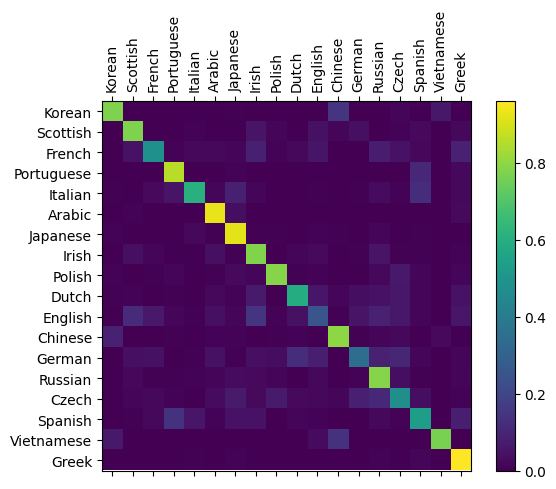

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)  # Initialize an empty confusion matrix
n_confusion = 10000  # Number of examples to evaluate for the confusion matrix

import matplotlib.pyplot as plt  # Importing matplotlib for plotting
import matplotlib.ticker as ticker  # Importing ticker for customizing ticks

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()  # Initialize the hidden state

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)  # Pass each character in the line through the RNN

    return output  # Return the final output of the RNN

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()  # Get a random training example
    output = evaluate(line_tensor)  # Evaluate the line tensor
    guess, guess_i = categoryFromOutput(output)  # Get the guessed category and its index
    category_i = all_categories.index(category)  # Get the true category index
    confusion[category_i][guess_i] += 1  # Increment the corresponding cell in the confusion matrix

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()  # Normalize each row

# Set up plot
fig = plt.figure()  # Create a new figure
ax = fig.add_subplot(111)  # Add a subplot to the figure
cax = ax.matshow(confusion.numpy())  # Display the confusion matrix as an image
fig.colorbar(cax)  # Add a color bar to the figure

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)  # Set x-axis labels with rotation
ax.set_yticklabels([''] + all_categories)  # Set y-axis labels

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Set x-axis major ticks
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))  # Set y-axis major ticks
plt.show()  # Show the plot

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


In [ ]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.20) Russian
(-1.80) Czech
(-4.95) English

> Jackson
(-0.11) Scottish
(-3.21) English
(-3.44) Russian

> Satoshi
(-0.63) Arabic
(-0.82) Japanese
(-4.26) Italian
